In [27]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim

In [28]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

In [29]:
len(train_dataset), len(test_dataset)

(60000, 10000)

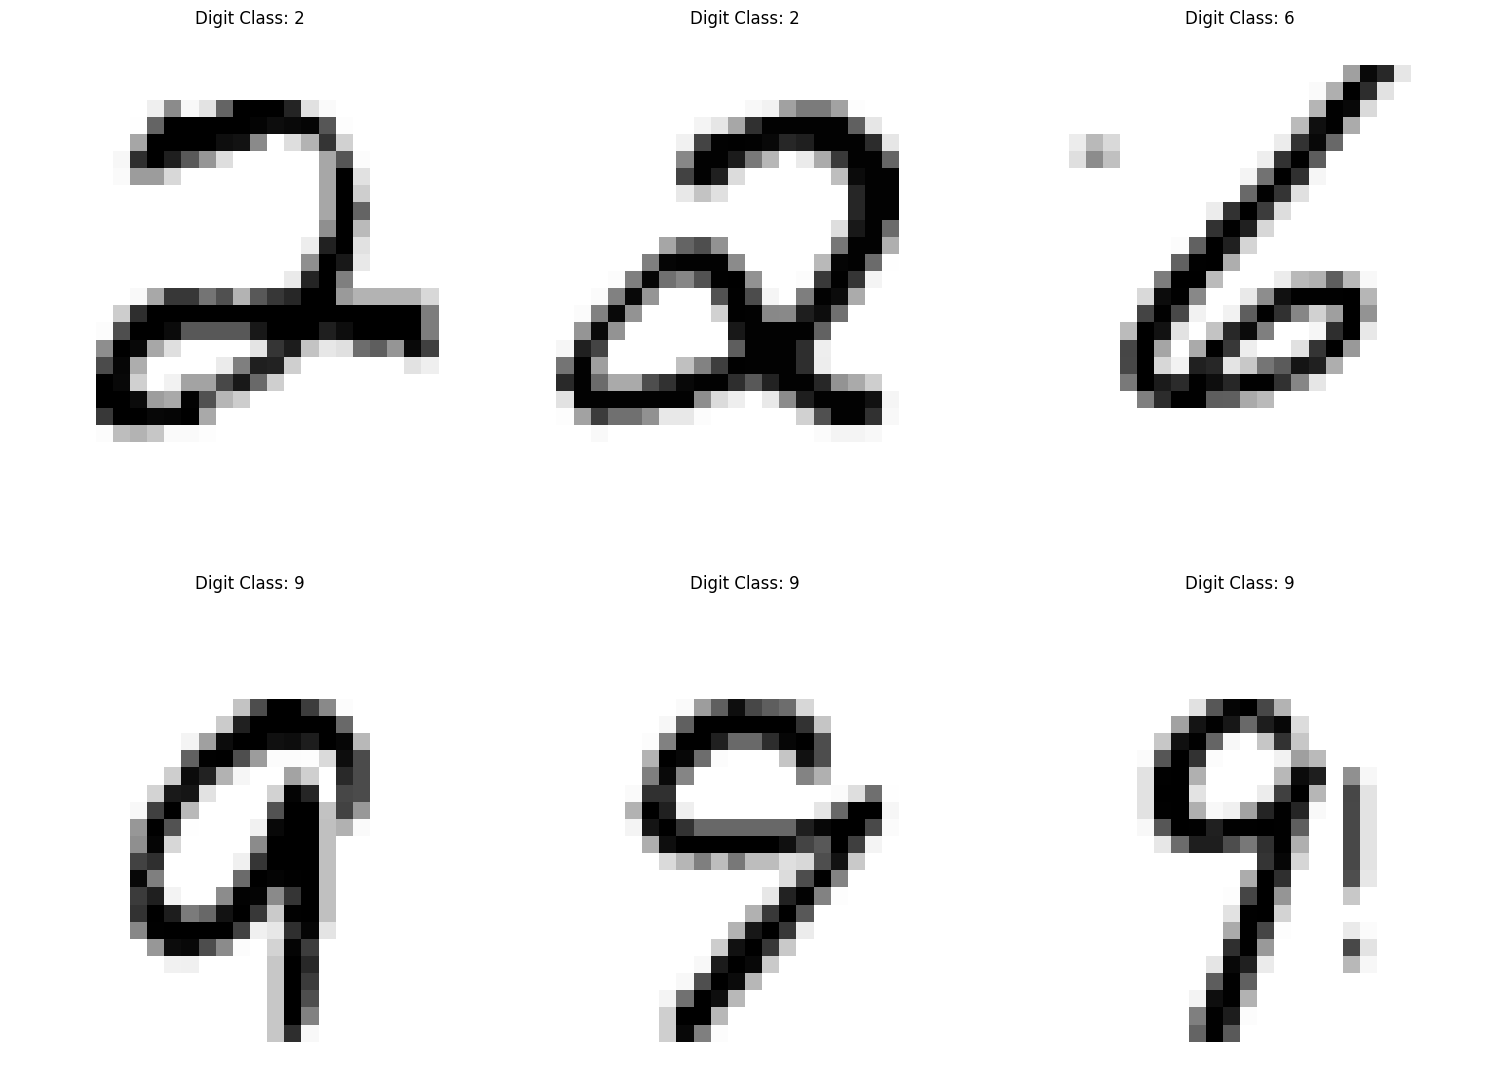

In [30]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [31]:
class ReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [32]:
class PReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.PReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.PReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [33]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     target_accuracy= None,
                     scheduler= None
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    patience= 5
    best_val_loss= float('inf')
    epochs_with_no_improvement= 0
    min_delta= 0.001

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)


        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc < best_val_loss - min_delta:
            best_val_loss= running_val_loss
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1


        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at epoch {epoch + 1}. No accuracy improvement after {patience} epochs")
            break

        if scheduler:
            scheduler.step()

    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


In [34]:
torch.manual_seed(42)
LEARNING_RATE= 0.01
TARGET_ACCURACY= 97
NUM_EPOCHS= 30
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

relu_model= ReLUMLP()
prelu_model= PReLUMLP()

relu_optimizer= optim.SGD(relu_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)
prelu_optimizer= optim.SGD(prelu_model.parameters(), lr= LEARNING_RATE, momentum= 0.9)

relu_scheduler= optim.lr_scheduler.CosineAnnealingLR(relu_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)
prelu_scheduler= optim.lr_scheduler.CosineAnnealingLR(prelu_optimizer, T_max= NUM_EPOCHS, eta_min= 0.001)

print(f"ReLU Model Training Starting...")
print(f"-"*80)
relu_model.to(device)
relu_model_metrics= train_eval_model(model= relu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= relu_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= relu_scheduler)
print(f"PReLU Model Training Starting...")
print(f"-"*80)
prelu_model.to(device)
prelu_model_metrics= train_eval_model(model= prelu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= prelu_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= prelu_scheduler)

print(f"-"*80)

ReLU Model Training Starting...
--------------------------------------------------------------------------------
Epoch 1/30 
----------
Train Loss: 0.3752
Train Accuracy: 89.00%
Val Loss: 0.1562
Val Accuracy: 95.04%
--------------------------------------------------
Epoch 2/30 
----------
Train Loss: 0.1248
Train Accuracy: 96.31%
Val Loss: 0.0966
Val Accuracy: 96.77%
--------------------------------------------------
Epoch 3/30 
----------
Train Loss: 0.0830
Train Accuracy: 97.48%
Val Loss: 0.0815
Val Accuracy: 97.43%
--------------------------------------------------
Epoch 4/30 
----------
Train Loss: 0.0611
Train Accuracy: 98.12%
Val Loss: 0.0743
Val Accuracy: 97.61%
--------------------------------------------------
Epoch 5/30 
----------
Train Loss: 0.0457
Train Accuracy: 98.61%
Val Loss: 0.0675
Val Accuracy: 97.82%
--------------------------------------------------
Epoch 6/30 
----------
Train Loss: 0.0354
Train Accuracy: 98.92%
Val Loss: 0.0789
Val Accuracy: 97.47%
--------------

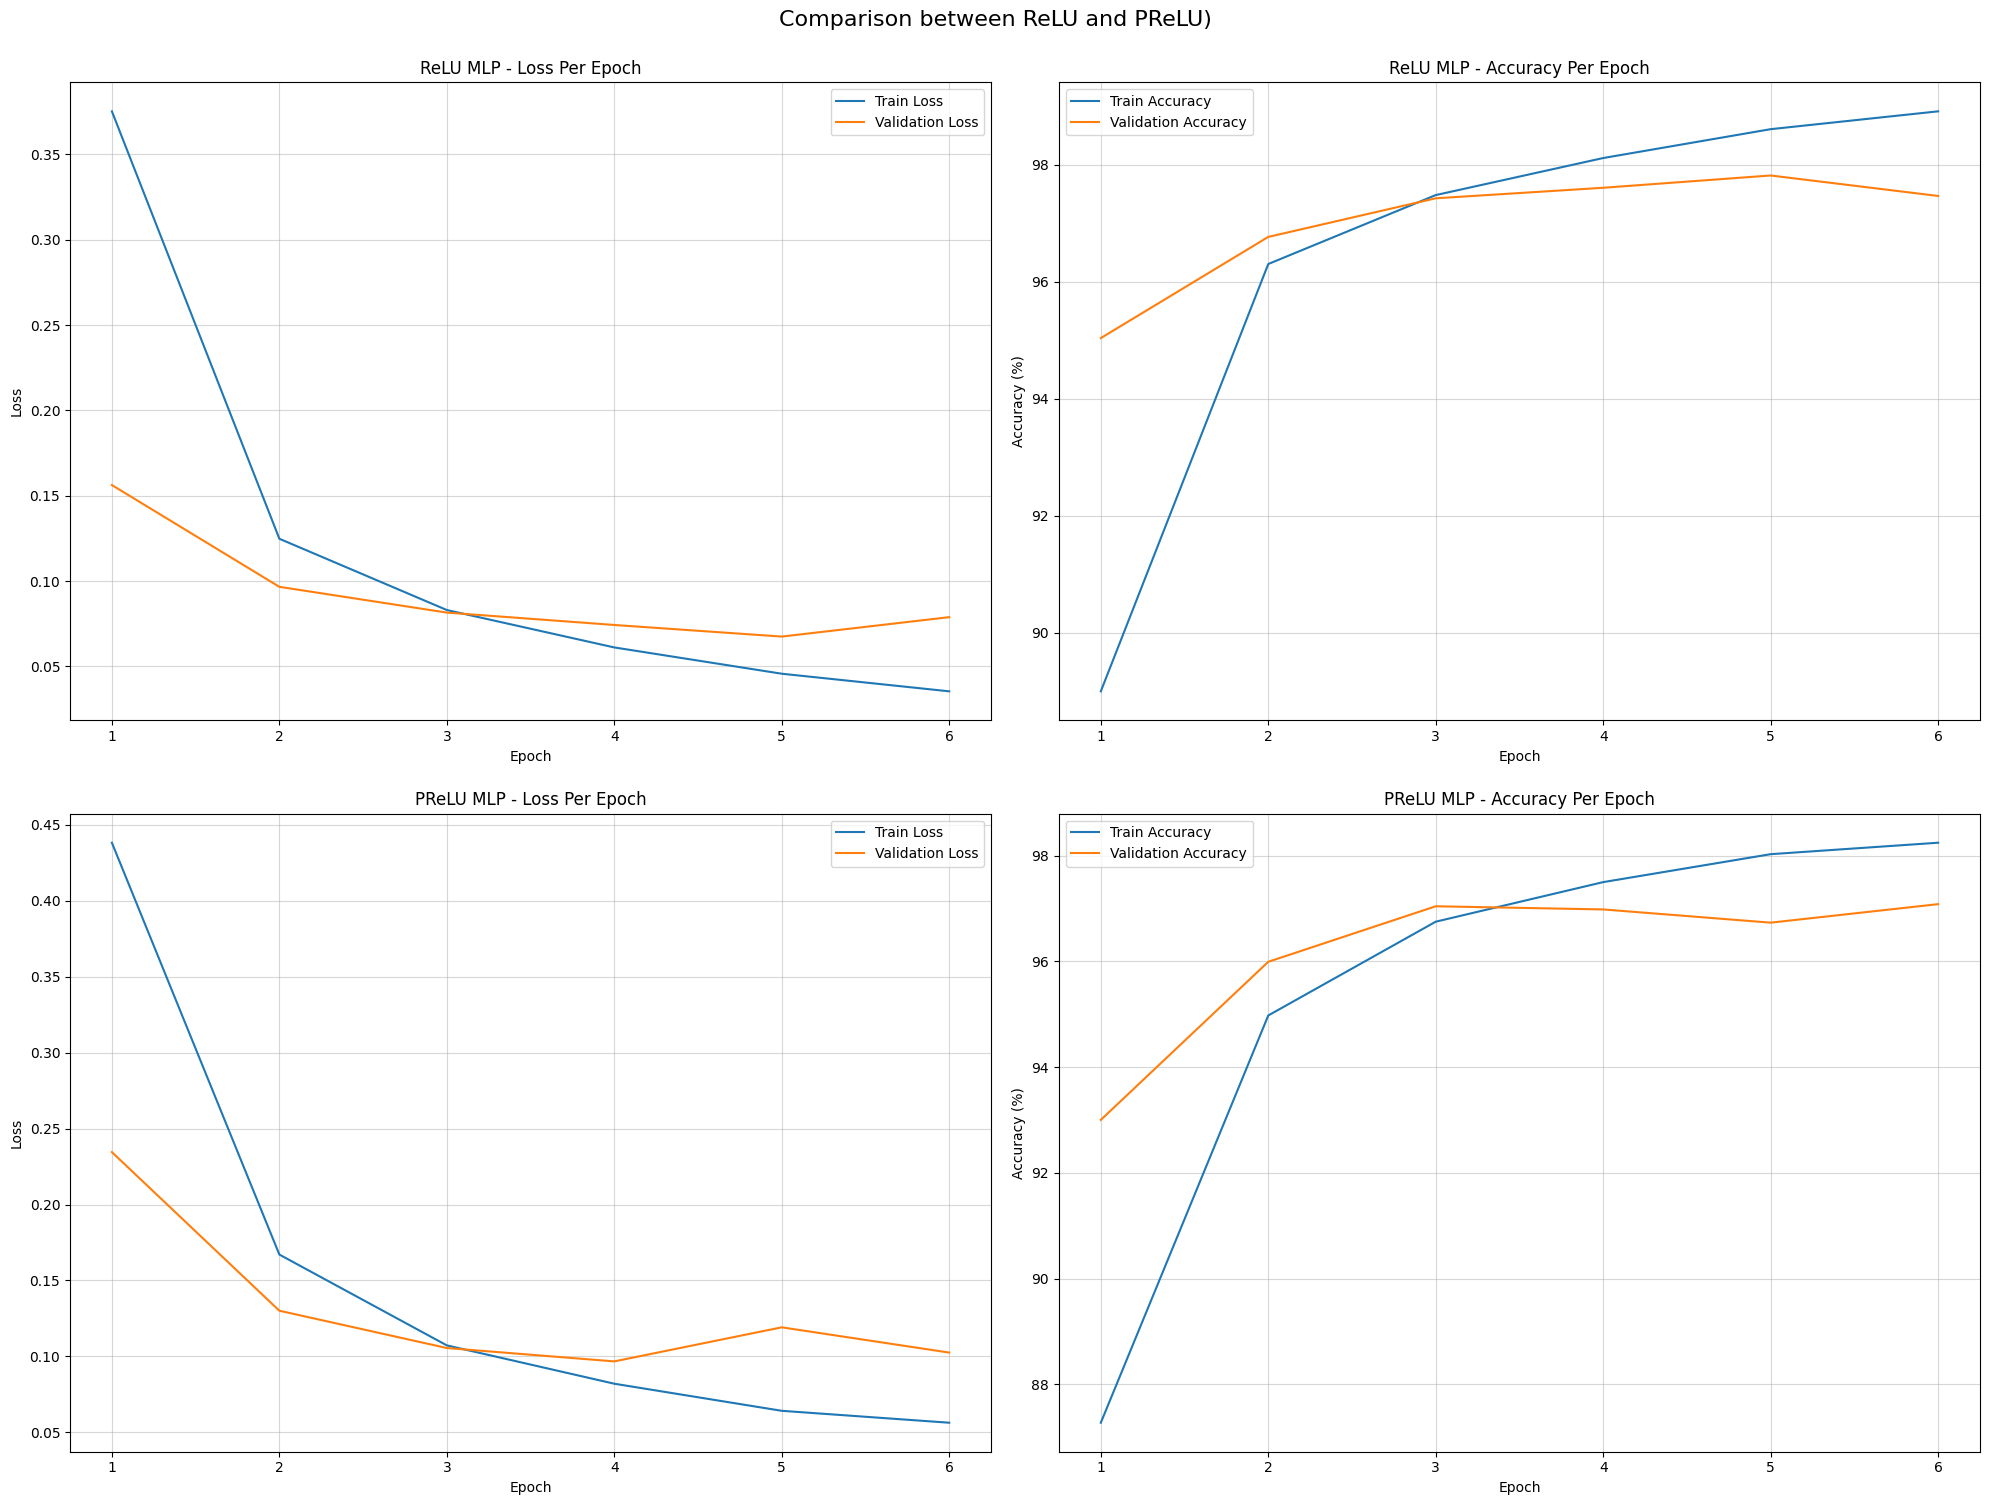

In [35]:
# Create figure with 5 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Data to plot (model metrics)
models_data = [
    (relu_model_metrics, "ReLU MLP"),
    (prelu_model_metrics, "PReLU MLP")
]

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"Comparison between ReLU and PReLU)",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()